In [7]:
import torchaudio
import torch

import os
import matplotlib.pyplot as plt
import IPython
from collections import Counter
import tqdm
import numpy as np

 https://www.tensorflow.org/datasets/catalog/speech_commands?spm=a2ty_o01.29997173.0.0.1198c921BLTjFt&hl=ru

In [2]:
DATA_DIR = os.path.abspath('../data')
SPEECHCOMMANDS_DATASET_PATH = os.path.join(DATA_DIR, "SPEECHCOMMANDS")

In [3]:
dataset = torchaudio.datasets.SPEECHCOMMANDS(SPEECHCOMMANDS_DATASET_PATH)

In [4]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    figure, ax = plt.subplots()
    ax.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()

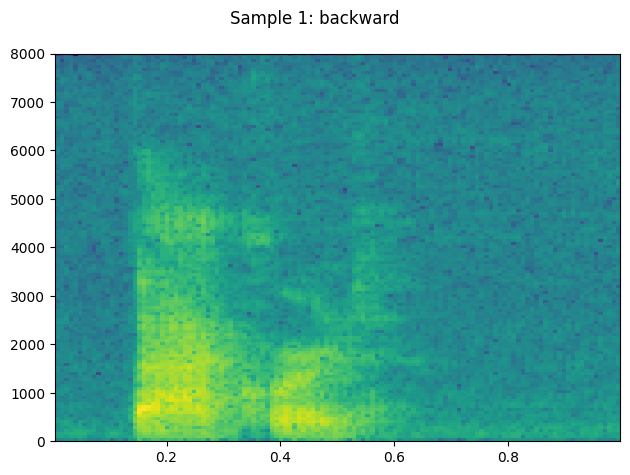

In [5]:
i=1
plot_specgram(dataset[i][0], dataset[i][1], title=f"Sample {i}: {dataset[i][2]}")
IPython.display.Audio(dataset[i][0], rate = dataset[i][1])

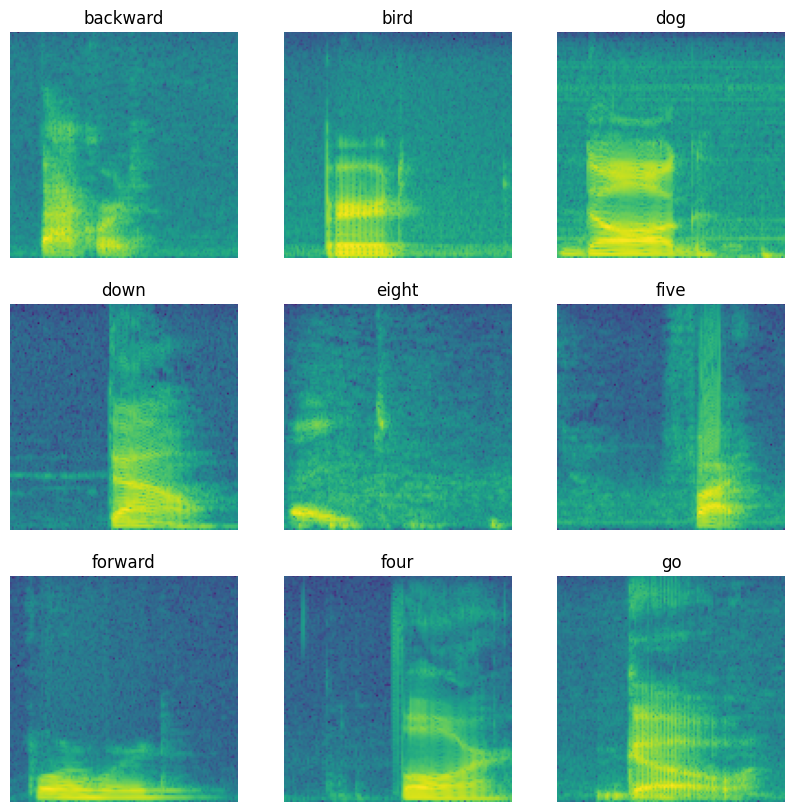

In [6]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(0, n):
  data = dataset[i*4000+1]
  waveform, sr, label = data[0], data[1], data[2]
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.specgram(waveform[0], Fs=sr)
  ax.set_title(label)
  ax.axis('off')
plt.show()

In [8]:
EXPECTED_SR = 16000 

def scan_uniformity(ds, expected_sr=EXPECTED_SR):
    """Проверяем, что у ВСЕХ сэмплов совпадают sample_rate и число отсчётов."""
    assert(expected_sr is not None)

    sr_counter = Counter()
    len_counter = Counter()
    for i in tqdm.tqdm(range(len(ds))):
        w, sr = ds[i][0], ds[i][1]
        sr_counter[sr] += 1
        L = w.shape[-1]
        len_counter[L] += 1

    
    if len(sr_counter) != 1 or (expected_sr not in sr_counter.keys()):
        raise RuntimeError(
            f"[UNIFORMITY CHECK FAILED] Неодинаковый sample_rate или не {expected_sr} Гц.\n"
            f"Встреченные SR: {dict(sr_counter)}"
        )
    
    if len(len_counter) != 1:
        most_common = len_counter.most_common(5)
        raise RuntimeError(
            "[UNIFORMITY CHECK FAILED] Разная длина сигналов (число отсчётов).\n"
            f"Топ-5 длин: {most_common}\n"
            f"Max {max(len_counter.keys())} Min {min(len_counter.keys())}"
        )

In [9]:
scan_uniformity(dataset)

100%|██████████| 105829/105829 [20:05<00:00, 87.75it/s]


RuntimeError: [UNIFORMITY CHECK FAILED] Разная длина сигналов (число отсчётов).
Топ-5 длин: [(16000, 95394), (14336, 696), (15702, 649), (15604, 575), (15019, 575)]
Max 16000 Min 3413

In [10]:
TARGET_LEN = 16000
def pad_or_trim_center(waveform, target_len=TARGET_LEN, pad_value=0.0):
    """
    Центрированное выравнивание длины аудиосигнала по последней оси.
    """
    L = waveform.shape[-1]
    if L == target_len:
        return waveform

    if L < target_len:
        total = target_len - L
        left = total // 2
        right = total - left
        return torch.nn.functional.pad(waveform, (left, right), mode="constant", value=pad_value)

    # L > target_len
    start = (L - target_len) // 2
    end = start + target_len
    return waveform[..., start:end]

In [11]:
N_FFT = 512
N_MELS = 128

mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=EXPECTED_SR, n_fft=N_FFT, n_mels=N_MELS, center=True, power=2.0
)

ampl2db = torchaudio.transforms.AmplitudeToDB(stype="power")

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


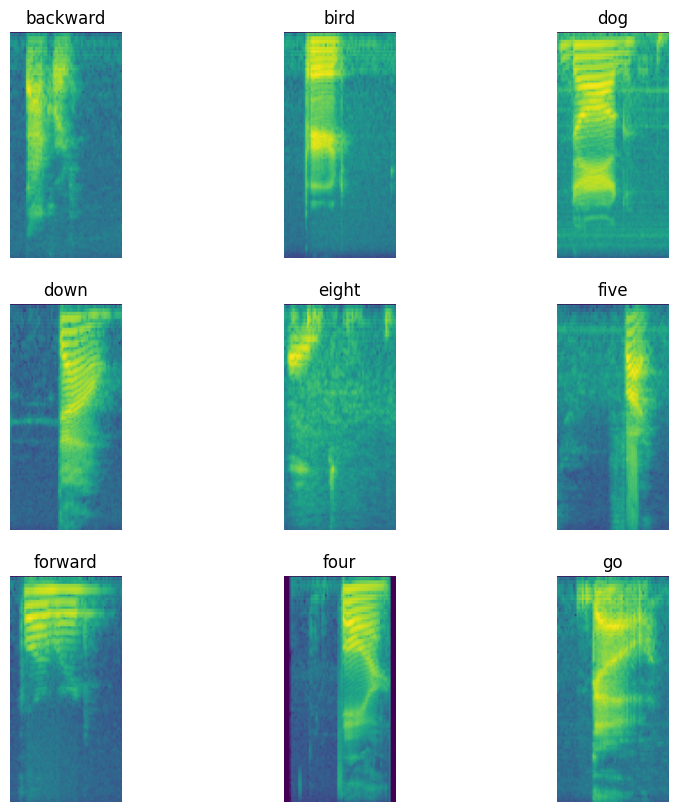

In [12]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(0, n):
  data = dataset[i*4000+1]
  waveform, sr, label = data[0], data[1], data[2]
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.imshow(ampl2db(mel(pad_or_trim_center(waveform)))[0])
  ax.set_title(label)
  ax.axis('off')
plt.show()